In [1]:
from google.cloud import bigquery
from google.cloud import bigquery_storage
creds = "/Users/srdeo/OneDrive - Copart, Inc/secrets/cprtpr-datastewards-sp1-614d7e297848 (1).json"
client = bigquery.Client.from_service_account_json(json_credentials_path=creds)
bqstorageclient = bigquery_storage.BigQueryReadClient(credentials=creds)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import warnings
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

### Extracting Churn Members

In [3]:
from datetime import datetime, timedelta
import pandas as pd

# Generate list of month starts from May 2024 to April 2025
month_starts = pd.date_range(start='2024-11-01', end='2025-04-01', freq='MS')

query_parts = []

for start_date in month_starts:
    end_date = (start_date + pd.offsets.MonthEnd(1)).date()
    month_label = start_date.strftime('%Y-%m')
    start_str = start_date.strftime('%Y-%m-%d')
    end_str = end_date.strftime('%Y-%m-%d')

    # Non-churn block
    non_churn = f"""
    SELECT
        m.owner_mbr_nbr,
        m.mbr_nbr,
        m.mbr_type,
        m.mbr_mbrshp_type_cd,
        e.event_type,
        e.event_value,
        DATE_TRUNC(e.event_value, MONTH) AS event_month,
        '{month_label}' AS month_label,
        0 AS churn
    FROM `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
    JOIN `cprtpr-dataplatform-sp1`.usmart.v_us_member_events_fact e
        ON m.mbr_nbr = e.mbr_nbr
    WHERE m.mbr_type = 'PREMIER'
      AND e.event_type = 'Member Premier Renewal Paid Date'
      AND e.event_value BETWEEN '{start_str}' AND '{end_str}'
    """

    # Churn block
    churn = f"""
    SELECT
        m.owner_mbr_nbr,
        m.mbr_nbr,
        m.mbr_type,
        m.mbr_mbrshp_type_cd,
        e.event_type,
        e.event_value,
        DATE_TRUNC(e.event_value, MONTH) AS event_month,
        '{month_label}' AS month_label,
        1 AS churn
    FROM `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
    JOIN `cprtpr-dataplatform-sp1`.usmart.v_us_member_events_fact e
        ON m.mbr_nbr = e.mbr_nbr
    WHERE m.mbr_type = 'LPSDPREMIER'
      AND e.event_type = 'MEMBER TYPE UPDATED FROM PREMIER TO GUEST'
      AND e.event_value BETWEEN '{start_str}' AND '{end_str}'
    """

    query_parts.append(non_churn)
    query_parts.append(churn)

# Combine all parts with UNION ALL
final_query = "\nUNION ALL\n".join(query_parts)

# Run the query
data1 = client.query(final_query).to_dataframe()


* trying it using new logic (1 query)

In [37]:
from datetime import datetime, timedelta
import pandas as pd

# Generate list of month starts from Nov 2024 to April 2025
month_starts = pd.date_range(start='2024-11-01', end='2025-04-01', freq='MS')

query_parts = []

for start_date in month_starts:
    end_date = (start_date + pd.offsets.MonthEnd(1)).date()
    month_label = start_date.strftime('%Y-%m')
    start_str = start_date.strftime('%Y-%m-%d')
    end_str = end_date.strftime('%Y-%m-%d')

    # Combined block with CASE WHEN for churn
    query = f"""
    SELECT
        m.owner_mbr_nbr,
        m.mbr_nbr,
        m.mbr_type,
        m.mbr_mbrshp_type_cd,
        e.event_type,
        e.event_value,
        DATE_TRUNC(e.event_value, MONTH) AS event_month,
        '{month_label}' AS month_label,
        CASE
            WHEN m.mbr_type = 'LPSDPREMIER' AND e.event_type = 'MEMBER TYPE UPDATED FROM PREMIER TO GUEST' THEN 1
            WHEN m.mbr_type = 'PREMIER' AND e.event_type = 'Member Premier Renewal Paid Date' THEN 0
            ELSE NULL
        END AS churn
    FROM `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
    JOIN `cprtpr-dataplatform-sp1`.usmart.v_us_member_events_fact e
        ON m.mbr_nbr = e.mbr_nbr
    WHERE (
        (m.mbr_type = 'PREMIER' AND e.event_type = 'Member Premier Renewal Paid Date') OR
        (m.mbr_type = 'LPSDPREMIER' AND e.event_type = 'MEMBER TYPE UPDATED FROM PREMIER TO GUEST')
    )
      AND e.event_value BETWEEN '{start_str}' AND '{end_str}'
    """

    query_parts.append(query)

# Combine all parts with UNION ALL
final_query = "\nUNION ALL\n".join(query_parts)

# Run the query
data2 = client.query(final_query).to_dataframe()

* Results after using the new logic (single query)

In [39]:
data2
print(data2.shape)
print(data2.isnull().sum())
print(data2['churn'].value_counts())
print(data2['month_label'].value_counts().sort_index())

,owner_mbr_nbr,mbr_nbr,mbr_type,mbr_mbrshp_type_cd,event_type,event_value,event_month,month_label,churn
0,889710,889710,PREMIER,PREMIER,Member Premier Renewal Paid Date,2025-04-04 03:01:19+00:00,2025-04-01 00:00:00+00:00,2025-04,0
1,859868,859868,PREMIER,PREMIER,Member Premier Renewal Paid Date,2025-04-27 23:34:17+00:00,2025-04-01 00:00:00+00:00,2025-04,0
2,865761,865761,PREMIER,PREMIER,Member Premier Renewal Paid Date,2025-04-28 13:28:15+00:00,2025-04-01 00:00:00+00:00,2025-04,0
3,865404,865404,PREMIER,PREMIER,Member Premier Renewal Paid Date,2025-04-21 13:59:39+00:00,2025-04-01 00:00:00+00:00,2025-04,0
4,871719,871719,PREMIER,PREMIER,Member Premier Renewal Paid Date,2025-04-09 13:23:08+00:00,2025-04-01 00:00:00+00:00,2025-04,0
...,...,...,...,...,...,...,...,...,...
42731,178928,178928,LPSDPREMIER,GUEST,MEMBER TYPE UPDATED FROM PREMIER TO GUEST,2024-11-23 11:00:48+00:00,2024-11-01 00:00:00+00:00,2024-11,1
42732,169230,169230,LPSDPREMIER,GUEST,MEMBER TYPE UPDATED FROM PREMIER TO GUEST,2024-11-01 10:01:46+00:00,2024-11-01 00:00:00+00:00,2024-11,1
42733,361654,361654,LPSDPREMIER,GUEST,MEMBER TYPE UPDATED FROM PREMIER TO GUEST,2024-11-15 20:26:24+00:00,2024-11-01 00:00:00+00:00,2024-11,1
42734,406490,406490,LPSDPREMIER,GUEST,MEMBER TYPE UPDATED FROM PREMIER TO GUEST,2024-11-20 11:00:14+00:00,2024-11-01 00:00:00+00:00,2024-11,1


(42736, 9)
owner_mbr_nbr         0
mbr_nbr               0
mbr_type              0
mbr_mbrshp_type_cd    0
event_type            0
event_value           0
event_month           0
month_label           0
churn                 0
dtype: int64
churn
0    22882
1    19854
Name: count, dtype: Int64
month_label
2024-11    5136
2024-12    8405
2025-01    8426
2025-02    6636
2025-03    7706
2025-04    6427
Name: count, dtype: int64


* Results after using the previous logic (multiple queries)

In [4]:
data1
print(data1.shape)
print(data1.isnull().sum())
print(data1['churn'].value_counts())
print(data1['month_label'].value_counts().sort_index())

,owner_mbr_nbr,mbr_nbr,mbr_type,mbr_mbrshp_type_cd,event_type,event_value,event_month,month_label,churn
0,664594,664594,LPSDPREMIER,GUEST,MEMBER TYPE UPDATED FROM PREMIER TO GUEST,2025-04-21 14:19:46+00:00,2025-04-01 00:00:00+00:00,2025-04,1
1,939937,939937,LPSDPREMIER,GUEST,MEMBER TYPE UPDATED FROM PREMIER TO GUEST,2025-04-01 12:44:00+00:00,2025-04-01 00:00:00+00:00,2025-04,1
2,932410,932410,LPSDPREMIER,GUEST,MEMBER TYPE UPDATED FROM PREMIER TO GUEST,2025-04-05 15:05:10+00:00,2025-04-01 00:00:00+00:00,2025-04,1
3,388998,388998,LPSDPREMIER,GUEST,MEMBER TYPE UPDATED FROM PREMIER TO GUEST,2025-04-02 10:00:12+00:00,2025-04-01 00:00:00+00:00,2025-04,1
4,83140,83140,LPSDPREMIER,GUEST,MEMBER TYPE UPDATED FROM PREMIER TO GUEST,2025-04-07 10:00:08+00:00,2025-04-01 00:00:00+00:00,2025-04,1
...,...,...,...,...,...,...,...,...,...
42735,2425,2425,PREMIER,PREMIER,Member Premier Renewal Paid Date,2024-11-27 23:02:30+00:00,2024-11-01 00:00:00+00:00,2024-11,0
42736,906266,906266,PREMIER,PREMIER,Member Premier Renewal Paid Date,2024-11-22 09:03:28+00:00,2024-11-01 00:00:00+00:00,2024-11,0
42737,430223,430223,PREMIER,PREMIER,Member Premier Renewal Paid Date,2024-11-20 17:38:36+00:00,2024-11-01 00:00:00+00:00,2024-11,0
42738,334507,334507,PREMIER,PREMIER,Member Premier Renewal Paid Date,2024-11-01 01:01:06+00:00,2024-11-01 00:00:00+00:00,2024-11,0


(42740, 9)
owner_mbr_nbr         0
mbr_nbr               0
mbr_type              0
mbr_mbrshp_type_cd    0
event_type            0
event_value           0
event_month           0
month_label           0
churn                 0
dtype: int64
churn
0    22883
1    19857
Name: count, dtype: Int64
month_label
2024-11    5136
2024-12    8406
2025-01    8426
2025-02    6637
2025-03    7707
2025-04    6428
Name: count, dtype: int64


#### New logic = Old logic

In [5]:
# Ensure 'month_label' is in string format like '2024-05'
unique_months = data1['month_label'].unique()

for month in unique_months:
    # Filter for that month
    df_month = data1[data1['month_label'] == month]

    # Extract lists
    churn_list = df_month[df_month['churn'] == 1]['owner_mbr_nbr'].unique().tolist()
    not_churn_list = df_month[df_month['churn'] == 0]['owner_mbr_nbr'].unique().tolist()

    # Create valid variable names: 'churn_members_may_2024', etc.
    var_suffix = pd.to_datetime(month).strftime('%B_%Y').lower()

    # Store in dynamically named lists
    globals()[f"churn_members_{var_suffix}"] = churn_list
    globals()[f"not_churn_members_{var_suffix}"] = not_churn_list


In [6]:
# Reuse the same month list from data1
unique_months = data1['month_label'].unique()

for month in unique_months:
    var_suffix = pd.to_datetime(month).strftime('%B_%Y').lower()

    # Get churn and not churn lists by name
    churn_members = globals().get(f"churn_members_{var_suffix}", [])
    not_churn_members = globals().get(f"not_churn_members_{var_suffix}", [])

    # Combine and deduplicate
    all_members = pd.unique(churn_members + not_churn_members).tolist()

    # Save as new variable
    globals()[f"all_members_{var_suffix}"] = all_members

In [7]:
# Loop through each month's member list
unique_months = data1['month_label'].unique()

for month in unique_months:
    var_suffix = pd.to_datetime(month).strftime('%B_%Y').lower()

    # Get all_members list for this month
    all_members = globals().get(f"all_members_{var_suffix}", [])

    # Convert to list of strings (no quotes)
    all_members_list = [str(x) for x in all_members]

    # Join into comma-separated string
    all_members_str = ", ".join(all_members_list)

    # Store both
    globals()[f"all_members_list_{var_suffix}"] = all_members_list
    globals()[f"all_members_str_{var_suffix}"] = all_members_str

### This loop extracts data for 1 year

In [8]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np

# Full month range from August 2024 to April 2025
month_range = [
    "2024-11", "2024-12",
    "2025-01", "2025-02", "2025-03", "2025-04"
]

query_results = []

for churn_month in month_range:
    churn_dt = datetime.strptime(churn_month + "-01", "%Y-%m-%d")

    # Lookback window: 3 full calendar months before churn month
    start_dt = (churn_dt - relativedelta(months=6)).replace(day=1)
    end_dt = (churn_dt - relativedelta(days=1))  # Day before churn month

    start_str = start_dt.strftime("%Y-%m-%d")
    end_str = end_dt.strftime("%Y-%m-%d")

    month_key = churn_dt.strftime('%B').lower() + '_' + str(churn_dt.year)

    # Get churn list and all member string dynamically
    churn_members_list = globals()[f'churn_members_{month_key}']
    all_members_str = globals()[f'all_members_str_{month_key}']

    query = f"""
    WITH bids_placed AS (
      SELECT
        owner_mbr_nbr,
        m.mbr_state,
        m.mbr_country,
        m.member_sgmnt_type,
        COUNT(DISTINCT b.bid_id) AS total_bids_on_lots_sold,
        COUNT(DISTINCT b.lot_nbr) AS total_lots_placed_bids_on
      FROM `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
      LEFT JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_bids_fact b
        ON m.mbr_nbr = b.buyer_nbr
      LEFT JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact l
        ON l.lot_nbr = b.lot_nbr AND l.inv_dt BETWEEN '{start_str}' AND '{end_str}'
      WHERE owner_mbr_nbr IN ({all_members_str})
      GROUP BY owner_mbr_nbr, m.mbr_state, m.member_sgmnt_type, m.mbr_country
    ),

    lots_won AS (
      SELECT
        owner_mbr_nbr,
        COUNT(DISTINCT l.lot_nbr) AS total_lots_won
      FROM `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
      JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact l
        ON l.buyer_nbr = m.mbr_nbr
      WHERE inv_dt BETWEEN '{start_str}' AND '{end_str}'
        AND owner_mbr_nbr IN ({all_members_str})
      GROUP BY owner_mbr_nbr
    )

    SELECT
      b.owner_mbr_nbr,
      b.total_bids_on_lots_sold,
      b.total_lots_placed_bids_on,
      w.total_lots_won,
      b.mbr_state,
      b.mbr_country,
      b.member_sgmnt_type
    FROM bids_placed b
    LEFT JOIN lots_won w
      ON b.owner_mbr_nbr = w.owner_mbr_nbr
    """

    data = client.query(query).to_dataframe()

    # Post-processing
    data['churn'] = data['owner_mbr_nbr'].isin(churn_members_list).astype(int)
    data['bid_atleast_once'] = np.where(data['total_lots_placed_bids_on'] > 0, 1, 0)
    data['won_atleast_once'] = np.where(pd.isna(data['total_lots_won']), 0, 1)
    data.insert(0, 'month', churn_dt.strftime('%B'))

    query_results.append(data)

# Combine all results
final_df = pd.concat(query_results, ignore_index=True)

In [17]:
final_df
final_df.shape

,month,owner_mbr_nbr,total_bids_on_lots_sold,total_lots_placed_bids_on,total_lots_won,mbr_state,mbr_country,member_sgmnt_type,churn,bid_atleast_once,won_atleast_once
0,November,137110,182,39,1,FL,USA,Consumer,1,1,1
1,November,565632,9160,1823,33,TM,MEX,Exporter,0,1,1
2,November,421410,439,78,1,IA,USA,Consumer,0,1,1
3,November,727442,50883,6313,97,TX,USA,Dismantler,0,1,1
4,November,498513,800,132,6,UT,USA,Dealer,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
42678,April,105267,65,9,<NA>,TN,USA,Consumer,1,1,0
42679,April,279300,4300,923,<NA>,DE,USA,Consumer,1,1,0
42680,April,684320,4743,984,11,NG,NGA,Exporter,0,1,1
42681,April,416490,107,34,<NA>,NC,USA,Consumer,1,1,0


(42683, 11)

In [10]:
final_df['month'].value_counts()

month
January     8424
December    8396
March       7694
February    6634
April       6410
November    5125
Name: count, dtype: int64

In [11]:
final_df['churn'].value_counts()

churn
0    22861
1    19822
Name: count, dtype: int64

In [12]:
final_df.isnull().sum()

month                            0
owner_mbr_nbr                    0
total_bids_on_lots_sold          0
total_lots_placed_bids_on        0
total_lots_won               22092
mbr_state                        0
mbr_country                      0
member_sgmnt_type             1453
churn                            0
bid_atleast_once                 0
won_atleast_once                 0
dtype: int64

In [13]:
final_df_copy = final_df.copy()

In [14]:
final_df_copy['total_lots_won'] = final_df_copy['total_lots_won'].fillna(0)  # filling NaN values with 0

final_df_copy['member_sgmnt_type'] = final_df_copy['member_sgmnt_type'].fillna('NA')

In [16]:
with pd.ExcelWriter('churned_members_t-3_1year.xlsx', mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    final_df_copy.to_excel(writer, index=False, sheet_name='t-6-1year')
    # You can add more sheets if needed

### Next Steps
1. Remove redundant columns
2. Convert categorical columns to numerical
3. Train random forest model

In [19]:
final_df_copy.drop(columns=['bid_atleast_once','won_atleast_once'], inplace=True)

In [20]:
final_df_copy

,month,owner_mbr_nbr,total_bids_on_lots_sold,total_lots_placed_bids_on,total_lots_won,mbr_state,mbr_country,member_sgmnt_type,churn
0,November,137110,182,39,1,FL,USA,Consumer,1
1,November,565632,9160,1823,33,TM,MEX,Exporter,0
2,November,421410,439,78,1,IA,USA,Consumer,0
3,November,727442,50883,6313,97,TX,USA,Dismantler,0
4,November,498513,800,132,6,UT,USA,Dealer,0
...,...,...,...,...,...,...,...,...,...
42678,April,105267,65,9,0,TN,USA,Consumer,1
42679,April,279300,4300,923,0,DE,USA,Consumer,1
42680,April,684320,4743,984,11,NG,NGA,Exporter,0
42681,April,416490,107,34,0,NC,USA,Consumer,1


In [21]:
final_df_copy['churn'].value_counts()

churn
0    22861
1    19822
Name: count, dtype: int64

* Train test split - Nov to March will be used for training and April will be used for testing

In [22]:
final_df_copy_train = final_df_copy[final_df_copy['month'] != 'April']
final_df_copy_test = final_df_copy[final_df_copy['month'] == 'April']

In [23]:
X_train = final_df_copy_train.drop(columns=['churn', 'month', 'owner_mbr_nbr'])
y_train = final_df_copy_train['churn']

X_test = final_df_copy_test.drop(columns=['churn', 'month','owner_mbr_nbr'])
y_test = final_df_copy_test['churn']

In [24]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((36273, 6), (36273,), (6410, 6), (6410,))

In [25]:
import category_encoders as ce

encoder = ce.TargetEncoder(cols=['mbr_state','mbr_country'])
encoder.fit(X_train, y_train)

X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)  # Safe — uses only training stats

,verbose,0
,cols,"['mbr_state', 'mbr_country']"
,drop_invariant,False
,return_df,True
,handle_missing,'value'
,handle_unknown,'value'
,min_samples_leaf,20
,smoothing,10
,hierarchy,None


In [26]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(drop=None, sparse_output=False, handle_unknown='ignore')
encoder.fit(X_train[['member_sgmnt_type']])

encoded_train = encoder.transform(X_train[['member_sgmnt_type']])
encoded_test = encoder.transform(X_test[['member_sgmnt_type']])

encoded_cols = encoder.get_feature_names_out(['member_sgmnt_type'])

X_train[encoded_cols] = encoded_train
X_test[encoded_cols] = encoded_test

,categories,'auto'
,drop,None
,sparse_output,False
,dtype,<class 'numpy.float64'>
,handle_unknown,'ignore'
,min_frequency,None
,max_categories,None
,feature_name_combiner,'concat'


In [28]:
X_train.drop('member_sgmnt_type', axis=1, inplace=True)
X_test.drop('member_sgmnt_type', axis=1, inplace=True)

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score

# Step 1: Train basic Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Step 2: Predict on test set
y_pred = rf.predict(X_test)

# Step 3: Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Step 4: Precision and Recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"\nPrecision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Confusion Matrix:
[[1773  660]
 [ 887 3090]]

Precision: 0.8240
Recall:    0.7770


<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC Curve - Random Forest')

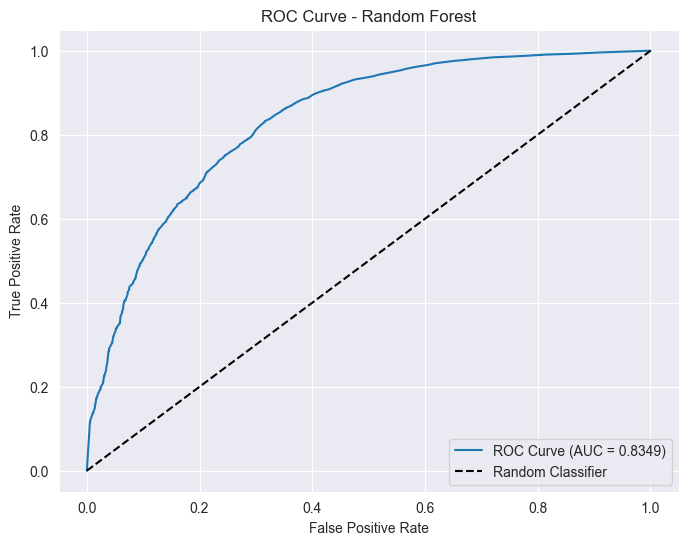

In [30]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Step 1: Get predicted probabilities for the positive class (churn = 1)
y_prob = rf.predict_proba(X_test)[:, 1]

# Step 2: Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Step 3: Plot the ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [31]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
import random
from sklearn.metrics import roc_auc_score

# Define the parameter distribution
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

n_iter = 10  # Number of iterations for random search
random.seed(42)
param_list = []
for _ in range(n_iter):
    params = {
        'n_estimators': param_dist['n_estimators'].rvs(),
        'max_depth': param_dist['max_depth'].rvs(),
        'min_samples_split': param_dist['min_samples_split'].rvs(),
        'min_samples_leaf': param_dist['min_samples_leaf'].rvs(),
        'max_features': random.choice(param_dist['max_features']),
        'bootstrap': random.choice(param_dist['bootstrap']),
    }
    param_list.append(params)

# Track best model and score
best_model = None
best_score = 0
best_params = None

for params in param_list:
    rf = RandomForestClassifier(**params, random_state=42)
    rf.fit(X_train, y_train)
    y_prob = rf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_prob)

    if auc > best_score:
        best_score = auc
        best_model = rf
        best_params = params

# Print best results
print("Best AUC:", round(best_score, 4))
print("Best Parameters:")
print(best_params)


,n_estimators,751
,criterion,'gini'
,max_depth,9
,min_samples_split,14
,min_samples_leaf,8
,min_weight_fraction_leaf,0.0
,max_features,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


,n_estimators,865
,criterion,'gini'
,max_depth,9
,min_samples_split,9
,min_samples_leaf,6
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,False
,oob_score,False


,n_estimators,216
,criterion,'gini'
,max_depth,41
,min_samples_split,9
,min_samples_leaf,7
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


,n_estimators,165
,criterion,'gini'
,max_depth,5
,min_samples_split,19
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


,n_estimators,239
,criterion,'gini'
,max_depth,12
,min_samples_split,15
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


,n_estimators,181
,criterion,'gini'
,max_depth,43
,min_samples_split,3
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,False
,oob_score,False


,n_estimators,488
,criterion,'gini'
,max_depth,47
,min_samples_split,15
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


,n_estimators,972
,criterion,'gini'
,max_depth,24
,min_samples_split,18
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


,n_estimators,726
,criterion,'gini'
,max_depth,11
,min_samples_split,9
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


,n_estimators,685
,criterion,'gini'
,max_depth,34
,min_samples_split,16
,min_samples_leaf,7
,min_weight_fraction_leaf,0.0
,max_features,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Best AUC: 0.8601
Best Parameters:
{'n_estimators': 865, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': False}



Confusion Matrix:
[[1739  694]
 [ 595 3382]]


<Axes: >

Text(0.5, 23.52222222222222, 'Predicted')

Text(50.72222222222221, 0.5, 'Actual')

Text(0.5, 1.0, 'Confusion Matrix')

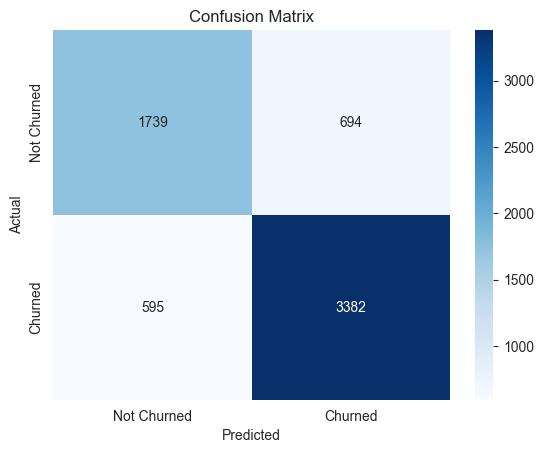


Precision: 0.8297
Recall:    0.8504


In [32]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Predict class labels at default threshold (0.5)
y_pred = best_model.predict(X_test)

# Step 2: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Optional: Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Churned', 'Churned'], yticklabels=['Not Churned', 'Churned'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Step 3: Precision and Recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"\nPrecision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

Best Threshold (Youden's J): 0.423


Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC Curve with Best Threshold')

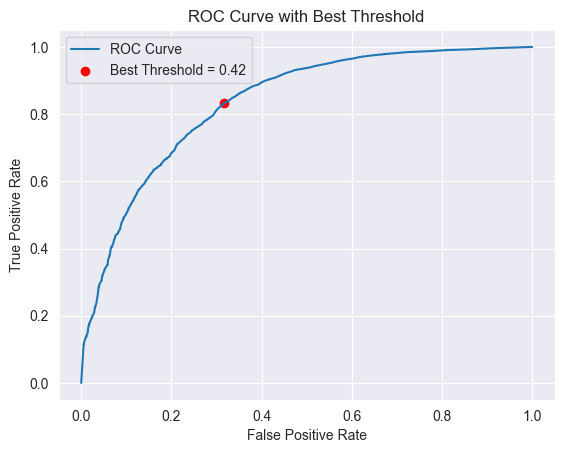

In [33]:
import numpy as np

j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
best_thresh = thresholds[best_idx]

print(f"Best Threshold (Youden's J): {best_thresh:.3f}")

plt.plot(fpr, tpr, label='ROC Curve')
plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Best Threshold = {best_thresh:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Best Threshold')
plt.legend()
plt.grid(True)
plt.show()


Confusion Matrix (Threshold = 0.42):
[[1608  825]
 [ 433 3544]]


<Axes: >

Text(0.5, 23.52222222222222, 'Predicted')

Text(50.72222222222221, 0.5, 'Actual')

Text(0.5, 1.0, 'Confusion Matrix (Threshold = 0.42)')

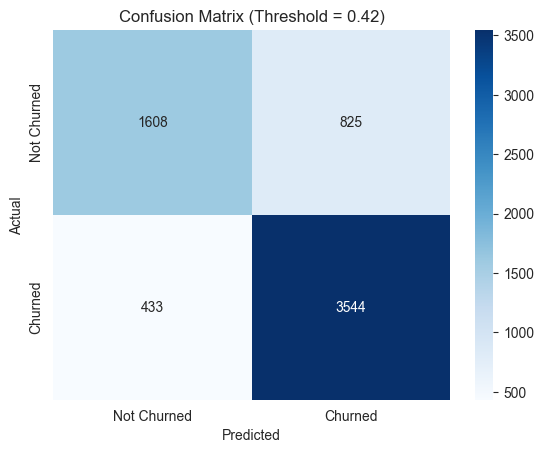


Precision: 0.8112
Recall:    0.8911
Accuracy:  0.8037


In [34]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Predict probabilities for the positive class (churn = 1)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Step 2: Apply custom threshold
custom_threshold = 0.42
y_pred = (y_prob >= custom_threshold).astype(int)

# Step 3: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix (Threshold = {custom_threshold}):")
print(cm)

# Step 4: Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Churned', 'Churned'],
            yticklabels=['Not Churned', 'Churned'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Threshold = {custom_threshold})')
plt.show()

# Step 5: Precision and Recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nPrecision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"Accuracy:  {accuracy:.4f}")

<Figure size 1000x600 with 0 Axes>

<BarContainer object of 11 artists>

Text(0.5, 1.0, 'Feature Importances - Random Forest')

Text(0.5, 0, 'Importance Score')

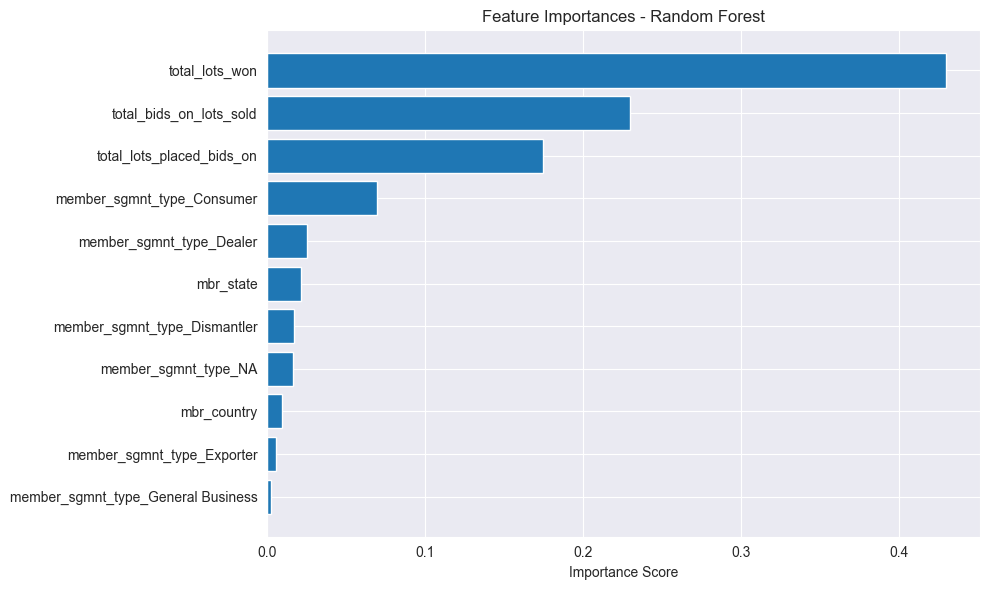

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Get feature importances and feature names
importances = best_model.feature_importances_
feature_names = X_train.columns

# Step 2: Create DataFrame for easy sorting
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Step 3: Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.gca().invert_yaxis()  # Most important on top
plt.title('Feature Importances - Random Forest')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

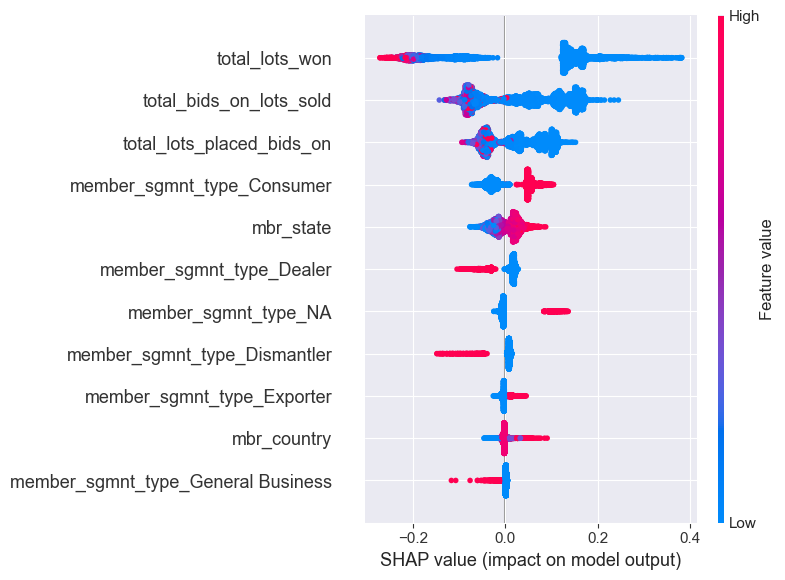

In [36]:
import shap

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# Extract SHAP values for class 1 (churn)
shap_values_churn = shap_values[:, :, 1]

# Now do the summary plot
shap.summary_plot(shap_values_churn, X_test)

In [40]:
# First, bring back the owner_mbr_nbr column (since X_test doesn't include it)
owner_mbr_nbrs = final_df_copy_test['owner_mbr_nbr'].reset_index(drop=True)

# Also reset the index of other components to align row-wise
y_test_reset = y_test.reset_index(drop=True)
y_pred_reset = pd.Series(y_pred).reset_index(drop=True)
y_prob_reset = pd.Series(y_prob).reset_index(drop=True)

# Combine all into one DataFrame
results_df = pd.DataFrame({
    'owner_mbr_nbr': owner_mbr_nbrs,
    'actual_churn': y_test_reset,
    'predicted_churn': y_pred_reset,
    'churn_probability': y_prob_reset
})

# Preview
results_df.head()


,owner_mbr_nbr,actual_churn,predicted_churn,churn_probability
0,933551,0,0,0.061017
1,113703,1,1,0.664671
2,396218,0,0,0.176981
3,108679,1,1,0.792263
4,127793,1,1,0.423951


In [41]:
results_df

,owner_mbr_nbr,actual_churn,predicted_churn,churn_probability
0,933551,0,0,0.061017
1,113703,1,1,0.664671
2,396218,0,0,0.176981
3,108679,1,1,0.792263
4,127793,1,1,0.423951
...,...,...,...,...
6405,105267,1,1,0.718078
6406,279300,1,1,0.458224
6407,684320,0,0,0.056172
6408,416490,1,1,0.710844


#### Actual Churn = 0 and predicted Churn = 1

In [42]:
results_df[(results_df['actual_churn'] == 0) & (results_df['churn_probability'] > 0.9)]

,owner_mbr_nbr,actual_churn,predicted_churn,churn_probability
300,713314,0,1,0.917720
728,354006,0,1,0.904405
796,160759,0,1,0.902104
1125,619239,0,1,0.900652
1598,641673,0,1,0.900668
1707,617778,0,1,0.901992
1989,265057,0,1,0.901992
2131,808256,0,1,0.910173
2162,708476,0,1,0.901876
2341,353367,0,1,0.901992


In [54]:

target_members = results_df[
    (results_df['actual_churn'] == 0) &
    (results_df['churn_probability'] > 0.8)
]

# Now filter from final_df_copy where mbr_country == 'USA' and owner_mbr_nbr is in that list
usa_high_prob_non_churners = final_df_copy[
    (final_df_copy['mbr_country'] == 'USA') &
    (final_df_copy['owner_mbr_nbr'].isin(target_members['owner_mbr_nbr']))
]

# View the result
usa_high_prob_non_churners

,month,owner_mbr_nbr,total_bids_on_lots_sold,total_lots_placed_bids_on,total_lots_won,mbr_state,mbr_country,member_sgmnt_type,churn
36284,April,616563,12,1,0,CA,USA,Consumer,0
36361,April,412229,24,1,0,NY,USA,Consumer,0
36444,April,6994,43,13,0,AZ,USA,Consumer,0
36460,April,657411,2,1,0,NJ,USA,Consumer,0
36498,April,243880,158,45,0,AZ,USA,Consumer,0
...,...,...,...,...,...,...,...,...,...
42277,April,313867,0,0,0,MA,USA,Consumer,0
42314,April,647969,21,3,0,MN,USA,Consumer,0
42391,April,67772,1,1,0,OK,USA,Consumer,0
42396,April,164847,0,0,0,FL,USA,Consumer,0


#### Actual Churn = 1 and predicted Churn = 0

In [56]:
results_df[(results_df['actual_churn'] == 1) & (results_df['churn_probability'] < 0.2)]

,owner_mbr_nbr,actual_churn,predicted_churn,churn_probability
69,822358,1,0,0.148722
78,126617,1,0,0.070911
141,73925,1,0,0.092175
146,569982,1,0,0.087767
148,114159,1,0,0.052619
...,...,...,...,...
6250,109526,1,0,0.163272
6276,113262,1,0,0.030953
6294,923548,1,0,0.143713
6360,509816,1,0,0.182256


In [57]:
target_members1 = results_df[
    (results_df['actual_churn'] == 1) &
    (results_df['churn_probability'] < 0.2)
]

# Now filter from final_df_copy where mbr_country == 'USA' and owner_mbr_nbr is in that list
usa_low_prob_churners = final_df_copy[
    (final_df_copy['mbr_country'] == 'USA') &
    (final_df_copy['owner_mbr_nbr'].isin(target_members1['owner_mbr_nbr']))
]

# View the result
usa_low_prob_churners

,month,owner_mbr_nbr,total_bids_on_lots_sold,total_lots_placed_bids_on,total_lots_won,mbr_state,mbr_country,member_sgmnt_type,churn
36351,April,126617,934,215,8,NC,USA,Dealer,1
36414,April,73925,594,82,7,AR,USA,Dealer,1
36452,April,203274,2772,738,12,AZ,USA,Dismantler,1
36534,April,512028,4532,772,46,FL,USA,Dealer,1
36646,April,358738,595,196,1,NC,USA,Dealer,1
...,...,...,...,...,...,...,...,...,...
42476,April,212692,1792,301,2,PA,USA,Dealer,1
42503,April,333216,549,135,15,SC,USA,Dealer,1
42523,April,109526,2044,289,1,NC,USA,Dealer,1
42549,April,113262,19224,4676,75,OH,USA,Dealer,1
